In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pip install -U libsvm-official

In [ ]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a

In [ ]:
from libsvm.svmutil import*

In [ ]:
train_y, train_x = svm_read_problem('a1a')

In [ ]:
train_y, train_x = svm_read_problem('a1a')
n_features = 123
X = np.zeros((len(train_y), n_features))
y = np.array(train_y)
for i, x_dict in enumerate(train_x):
    for idx, val in x_dict.items():
        X[i, idx - 1] = val  # LIBSVM uses 1-based indexing

# feature normalization
X = (X - X.mean(axis=0))/(X.std(axis=0) + 1e-8)

In [ ]:
def svm_loss(w, X, y, lambda_=5.0/123):
    margins = y*(X @ w)
    hinge = np.maximum(0, 1 - margins)**2  # Squared hinge loss
    return np.mean(hinge) + 0.5*lambda_*np.sum(w**2)

def svm_gradient(w, X, y, lambda_=5.0/123):
    margins = y*(X @ w)
    mask = (margins < 1).astype(float)
    grad_hinge = -2*(y*mask*(1 - margins))[:, None]*X
    return np.mean(grad_hinge, axis=0) + lambda_*w

In [ ]:
from tqdm import tqdm

def osgm_h_svm(X, y, lambda_, eta, num_iter=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    P = np.eye(n_features)
    history = []

    for k in range(num_iter):
        grad = svm_gradient(w, X, y, lambda_)
        grad_norm = np.linalg.norm(grad)

        # line search for step size
        alpha = 1.0
        while True:
            w_next = w - alpha*(P @ grad)
            if svm_loss(w_next, X, y, lambda_) < svm_loss(w, X, y, lambda_):
                break
            alpha *= 0.5
            if alpha < 1e-8: break

        h_x_P = (svm_loss(w_next, X, y, lambda_) - svm_loss(w, X, y, lambda_))/(grad_norm**2 + 1e-8)
        grad_w_next = svm_gradient(w_next, X, y, lambda_)
        surrogate_grad = -np.outer(grad_w_next, grad)/(grad_norm**2 + 1e-8)
        P = P - eta*np.diag(np.diag(surrogate_grad))*np.eye(n_features)

        w = w_next
        history.append(svm_loss(w, X, y, lambda_))

    return history

In [ ]:
def gd_svm(X, y, lambda_, lr=0.01, num_iter=100):
    w = np.zeros(X.shape[1])
    history = []
    for _ in range(num_iter):
        grad = svm_gradient(w, X, y, lambda_)
        w -= lr*grad
        history.append(svm_loss(w, X, y, lambda_))
    return w, history

In [ ]:
# learning rates
eta_values = [1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.1, 0.01, 0.001, 0.0001]
lambda_ = 5.0 / 123  # regularization parameter

# results
histories = {}
for eta in eta_values:
    print(f"Running OSGM-H with eta={eta}")
    histories[eta] = osgm_h_svm(X, y, lambda_, eta=eta, num_iter=100)

Running OSGM-H with eta=1.9
Running OSGM-H with eta=1.8
Running OSGM-H with eta=1.7
Running OSGM-H with eta=1.6
Running OSGM-H with eta=1.5
Running OSGM-H with eta=1.4
Running OSGM-H with eta=1.3
Running OSGM-H with eta=1.2
Running OSGM-H with eta=1.1
Running OSGM-H with eta=1.0
Running OSGM-H with eta=0.1
Running OSGM-H with eta=0.01
Running OSGM-H with eta=0.001
Running OSGM-H with eta=0.0001


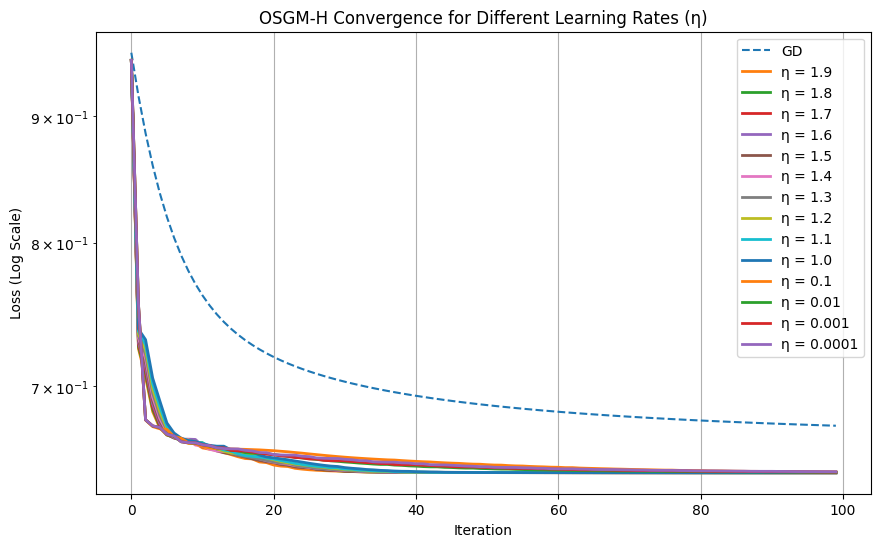

In [ ]:
plt.figure(figsize=(10, 6))

w_gd, hist_gd = gd_svm(X, y, lambda_, lr=0.01)
plt.plot(hist_gd, label='GD', linestyle='--')

for eta, history in histories.items():
    plt.plot(history, label=f"η = {eta}", linewidth=2)

plt.yscale('log')  # log scale for better visibility
plt.xlabel('Iteration')
plt.ylabel('Loss (Log Scale)')
plt.title('OSGM-H Convergence for Different Learning Rates (η)')
plt.legend()
plt.grid(True)
plt.show()